# Определение перспективного тарифа для телеком компании

#### Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
#### Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Оглавление:
* [Изучение общей информации](#step1)
* [Подготовка данных](#step2)
* [Анализ данных](#step3)
* [Проверка гипотез](#step4)
* [Выводы](#step5)

## Шаг 1. Откроем файлы и изучим общую информацию.<a class="anchor" id="step1"></a>
Импортируем нужные библиотеки, читаем файлы, смотрим общую информацию по таблицам.

In [1]:
from scipy import stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import *

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
for data in [calls, internet, messages, tariffs, users]:
    print(data.info())
    print(data.head(), end='\n\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
   Unnamed: 0      id  mb_used session_date  user_id
0      

##### Вывод
Данные содержат информацию о 500 клиентах, об их звонках, сообщениях, использованном трафике интернета и их тарифе. Необходимо будет изменить тип данных в столбцах с датой и временем, разобраться как поступить с пропускам и с нулевыми значениями в таблицах

## Шаг 2. Подготовка данных.<a class="anchor" id="step2"></a>

In [4]:
# приведем к нужному форматы столбцы с датой в каждой таблице
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [5]:
len(calls.query('duration == 0')) / len(calls)

0.19551644316336553

In [6]:
len(internet.query('mb_used == 0')) / len(internet)

0.13118155773916304

Скорее всего нулевые значения в продолжительности звоноков в минутах и в объеме потраченного интернет-трафика являются ошибкой, если звонки и могут считаться пропущенными, то с заходм в интернет такого быть не может. Вероятно система сама округляет до 0 значений. А так как оператор округляет всегда вверх значения минут и мегабайт, то заменим значения 0 на 1.

In [7]:
calls['duration'] = calls['duration'].replace(0, 1)
internet['mb_used'] = internet['mb_used'].replace(0, 1)

In [8]:
# округлим все минуты в большую сторону
def rnd(row):
    return ceil(row['duration'])

calls['duration'] = calls.apply(rnd, axis=1)

In [9]:
# добавим к нужным таблицам информацию по месяцам
calls['month'] = calls['call_date'].dt.month
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month

In [10]:
# создадим сводные таблицы по пользователям и месяцам для звонков, смс и интернета
calls_group = calls.groupby(['user_id','month'])[['duration']].agg(['sum','count']).reset_index()
calls_group.columns = ['user_id','month','duration_minut','calls']

In [11]:
calls_group.head(5)

,user_id,month,duration_minut,calls
0,1000,5,164,22
1,1000,6,187,43
2,1000,7,346,47
3,1000,8,418,52
4,1000,9,478,58


In [12]:
internet_group = internet.groupby(['user_id','month'])[['mb_used']].agg(['sum']).reset_index()
internet_group.columns = ['user_id','month','mb_used']

In [13]:
internet_group.head(5)

,user_id,month,mb_used
0,1000,5,2254.49
1,1000,6,23238.77
2,1000,7,14004.64
3,1000,8,14057.93
4,1000,9,14570.91


In [14]:
messages_group = messages.groupby(['user_id','month'])[['month']].agg(['count']).reset_index()
messages_group.columns = ['user_id','month','count_messages']

In [15]:
messages_group.head(5)

,user_id,month,count_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [16]:
# соединим получившиеся таблицы в одну
data = internet_group.merge(calls_group,how='outer',on=['user_id','month'])

In [17]:
data.head(5)

,user_id,month,mb_used,duration_minut,calls
0,1000,5,2254.49,164.0,22.0
1,1000,6,23238.77,187.0,43.0
2,1000,7,14004.64,346.0,47.0
3,1000,8,14057.93,418.0,52.0
4,1000,9,14570.91,478.0,58.0


In [18]:
data = data.merge(messages_group, how='outer', on=['user_id','month'])

In [19]:
data.head(5)

,user_id,month,mb_used,duration_minut,calls,count_messages
0,1000,5,2254.49,164.0,22.0,22.0
1,1000,6,23238.77,187.0,43.0,60.0
2,1000,7,14004.64,346.0,47.0,75.0
3,1000,8,14057.93,418.0,52.0,81.0
4,1000,9,14570.91,478.0,58.0,57.0


In [20]:
data = data.merge(users[['tariff','user_id']], on='user_id')

In [21]:
data.head(5)

,user_id,month,mb_used,duration_minut,calls,count_messages,tariff
0,1000,5,2254.49,164.0,22.0,22.0,ultra
1,1000,6,23238.77,187.0,43.0,60.0,ultra
2,1000,7,14004.64,346.0,47.0,75.0,ultra
3,1000,8,14057.93,418.0,52.0,81.0,ultra
4,1000,9,14570.91,478.0,58.0,57.0,ultra


In [22]:
# пустые значения заменим на 0
data = data.fillna(0)

In [23]:
data.sample(10)

,user_id,month,mb_used,duration_minut,calls,count_messages,tariff
637,1100,10,11930.43,564.0,79.0,56.0,smart
3177,1494,12,17626.21,426.0,62.0,0.0,smart
2538,1396,4,9348.97,495.0,57.0,88.0,ultra
2984,1466,5,14927.91,508.0,73.0,0.0,ultra
364,1057,7,17240.64,803.0,110.0,29.0,ultra
1024,1161,7,19550.37,303.0,37.0,44.0,smart
1314,1204,10,22944.78,330.0,41.0,0.0,smart
1766,1281,7,17451.89,525.0,72.0,71.0,ultra
1140,1178,6,13505.90,427.0,61.0,24.0,smart
1095,1173,8,16024.88,1028.0,137.0,13.0,smart


In [24]:
# создадим функцию для посчета ежемесячной выручки пок аждому пользователю
def revenue(row):
    tariff = row['tariff']
    duration_minut = row['duration_minut']
    count_messages = row['count_messages']
    mb_used = row['mb_used']
    
    if tariff == 'smart':
        over_duration_minut = duration_minut - tariffs.loc[0, 'minutes_included']
        over_mb = mb_used - tariffs.loc[0, 'mb_per_month_included']
        over_count_messages = count_messages - tariffs.loc[0, 'messages_included']
        
        if over_duration_minut < 0:
            over_duration_minut = 0
        if over_mb < 0:
            over_mb = 0
        if over_count_messages < 0:
            over_count_messages = 0
        
        return (tariffs.loc[0, 'rub_per_message'] * over_count_messages + (tariffs.loc[0, 'rub_per_gb'] / 1024) *
                over_mb + tariffs.loc[0, 'rub_per_minute'] * over_duration_minut + tariffs.loc[0, 'rub_monthly_fee']) 
    else:
        over_duration_minut = duration_minut - tariffs.loc[1, 'minutes_included']
        over_mb = mb_used - tariffs.loc[1, 'mb_per_month_included']
        over_count_messages = count_messages - tariffs.loc[1, 'messages_included']
        
        if over_duration_minut < 0:
            over_duration_minut = 0
        if over_mb < 0:
            over_mb = 0
        if over_count_messages < 0:
            over_count_messages = 0
        
        return (tariffs.loc[1, 'rub_per_message'] * over_count_messages + (tariffs.loc[1, 'rub_per_gb'] / 1024) * 
                over_mb + tariffs.loc[1, 'rub_per_minute'] * over_duration_minut + tariffs.loc[1, 'rub_monthly_fee'])

data['revenue'] = data.apply(revenue, axis=1)

In [25]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
user_id           3214 non-null int64
month             3214 non-null int64
mb_used           3214 non-null float64
duration_minut    3214 non-null float64
calls             3214 non-null float64
count_messages    3214 non-null float64
tariff            3214 non-null object
revenue           3214 non-null float64
dtypes: float64(5), int64(2), object(1)
memory usage: 226.0+ KB


,user_id,month,mb_used,duration_minut,calls,count_messages,tariff,revenue
0,1000,5,2254.49,164.0,22.0,22.0,ultra,1950.000000
1,1000,6,23238.77,187.0,43.0,60.0,ultra,1950.000000
2,1000,7,14004.64,346.0,47.0,75.0,ultra,1950.000000
3,1000,8,14057.93,418.0,52.0,81.0,ultra,1950.000000
4,1000,9,14570.91,478.0,58.0,57.0,ultra,1950.000000
5,1000,10,14702.49,363.0,57.0,73.0,ultra,1950.000000
6,1000,11,14757.47,344.0,43.0,58.0,ultra,1950.000000
7,1000,12,9819.61,341.0,46.0,70.0,ultra,1950.000000
8,1001,11,18437.34,444.0,59.0,0.0,smart,1151.042969
9,1001,12,14042.66,430.0,63.0,0.0,smart,550.000000


## Шаг 3. Проанализируем данные.<a class="anchor" id="step3"></a>

##### Создадим таблицу `statistics_data` с основными описательными статистиками: медианой, средним,  дисперсией и стандартным отклонением.

In [26]:
statistics_data = data.pivot_table(index = ['tariff'], 
                                   values = ['duration_minut', 'count_messages', 'mb_used'], 
                                   aggfunc=['median','mean', 'var', 'std']
                                  )
statistics_data

median                                    mean                 \
       count_messages duration_minut   mb_used count_messages duration_minut   
tariff                                                                         
smart            28.0          435.0  16515.84      33.384029     429.450875   
ultra            38.0          532.0  19308.01      49.363452     540.779695   

                                var                               \
             mb_used count_messages duration_minut       mb_used   
tariff                                                             
smart   16216.382952     796.812958   37974.774628  3.448854e+07   
ultra   19470.607239    2285.266143  106105.726823  1.017670e+08   

                  std                               
       count_messages duration_minut       mb_used  
tariff                                              
smart       28.227876     194.871174   5872.694696  
ultra       47.804457     325.738740  10087.961075

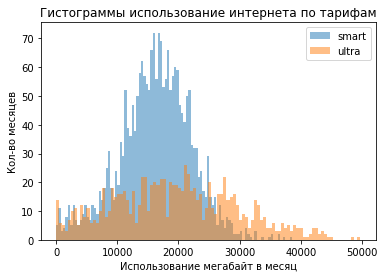

In [27]:
# Будем строить гистограммы по месячному использованию интернета, смс и минут для каждого из тарифов
ax = plt.hist(x=data.query('tariff == "smart"')['mb_used'],  bins=100, alpha = 0.5, label  = 'smart')
plt.hist(x=data.query('tariff == "ultra"')['mb_used'],  bins=100, alpha = 0.5, label = 'ultra')
plt.ylabel('Кол-во месяцев')
plt.xlabel('Использование мегабайт в месяц')
plt.title('Гистограммы использование интернета по тарифам')
plt.legend()

#####  Выводы по графику:
1. Из графика мы видим, что у обоих тарифов распределение **нормальное**. Из таблицы `statistics_data` мы точно знаем что пик для тарифа Смарт прихоится на ~16300мб в месяц, а пик Ультра на ~19400мб в месяц. В целом с учетом размытости пика тарифа Ультра( стандартное отклонение почти в 2 раза больше чем у тарифа Смарт) и общим разбросом от 0 до 50000 значения достоточно близкие.
2. Очень мало людей которые не использую инетрнет вовсе.
3. Среди пользователей тарифа Ультра есть приличная доля клиентов, которые используют больше 30000мб в мес, в том время как пользователи тарифа Смарт практически никогда не выходят за этот порог. Однако если учесть, что что объем интернет-трафика включенного в абанентскую плату для тарифа Смарт составляет всего 15360 мб (Ультра - 30720 мб), то сразу становится очевидно, что больше половины клиентов выходят за лимит(среди пользователей Ультра процент таких клиентов гораздо меньше).

In [28]:
# процент пользователей Ультра, которые переплачивают за интернет
len(data.query('tariff == "ultra" and mb_used > 30720')) / len(data.query('tariff == "ultra"'))

0.13604060913705585

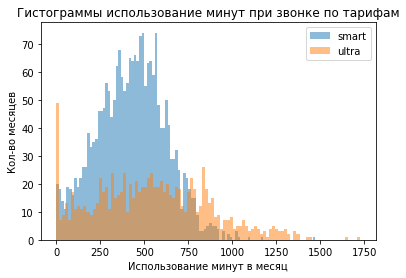

In [29]:
ax = plt.hist(x=data.query('tariff == "smart"')['duration_minut'],  bins=100, alpha = 0.5, label  = 'smart')
plt.hist(x=data.query('tariff == "ultra"')['duration_minut'],  bins=100, alpha = 0.5, label = 'ultra')
plt.ylabel('Кол-во месяцев')
plt.xlabel('Использование минут в месяц')
plt.title('Гистограммы использование минут при звонке по тарифам')
plt.legend()

#####  Выводы по графику:
1. Из графика мы видим, что у обоих тарифов так же распределение **нормальное**. Хотя для тарифа Ультра пик опять очень сглажен( снова стандартное отклонение изходя из таблицы `statistics_data` почти в 2 раза больше), в среднем для обоих тарифов клиенты в большинстве случаев используют от 400 до 600 минут в месяц.
2. Здесь гораздо больше людей которые не совершают звонки, особенно среди пользователей тарифа Ультра. 
3. Опять же просматривается тенденция, что пользователи тарифа Смарт выходят за ограничение по минутам в месяц, включенным в абонентскую плату - 500мин/мес. А если точнее, то немного меньше половины пользователей, т.к медиана = 435. Пользователи же тарифа Ультра вообще не выговаривают даже половины своих минут(3000 мин/мес).

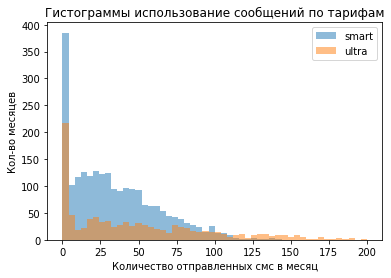

In [30]:
ax = plt.hist(x=data.query('tariff == "smart"')['count_messages'],  bins=50, alpha = 0.5, range=(0, 200), label  = 'smart')
plt.hist(x=data.query('tariff == "ultra"')['count_messages'],  bins=50, alpha = 0.5, range=(0, 200), label = 'ultra')
plt.ylabel('Кол-во месяцев')
plt.xlabel('Количество отправленных смс в месяц')
plt.title('Гистограммы использование сообщений по тарифам')
plt.legend()

##  Шаг 4. Проверим гипотезы.<a class="anchor" id="step4"></a>

In [31]:
# создадим два массива содержащие выборки по двум тарифам
smart = data.query('tariff == "smart" ')['revenue']
ultra = data.query('tariff == "ultra" ')['revenue']

In [32]:
alpha = .01
print(f'Средний доход тарифа Смарт = {smart.mean()}')
print(f'Средний доход тарифа Ультра = {ultra.mean()}')
results = st.ttest_ind(smart, ultra)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Средний доход тарифа Смарт = 1248.4999938663639
Средний доход тарифа Ультра = 2059.9303368892765
p-значение: 1.6437863652252344e-181
Отвергаем нулевую гипотезу


##### Вывод:
Тест показал, что средняя выручка двух тарифов неодинакова, а цифры, которые я вывел - 1248 и 2060 - показывают, в какую сторону они неодинаковы. Т.е можно сделать вывод, что в среднем пользователи тарифа Ультра приносят почти в 2 раза больше доход компании, чем пользователи тарифа Смарт.

#### Вторая гипотеза. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
Сформулируем гипотезу:

**Н0** - средняя выручка пользователей Москвы **равна** средней выручке пользователей остальных регионов.

**Н1** - средние вырчукы этих пользователей **не равны**. 

Здесь логика точно такая же, как в предыдущем тесте: сравниваем выборки двух генеральных совокупностей. Критический уровень статистической значимости - **0.01**.

In [33]:
# добавим столбец с городом
data = data.merge(users[['city','user_id']], on='user_id')

In [34]:
moscow = data.query('city == "Москва" ')['revenue']
other = data.query('city != "Москва" ')['revenue']

alpha = .01

print(f'Средний доход по Москве = {moscow.mean()}')
print(f'Средний доход по другим регионам = {other.mean()}')
results = st.ttest_ind(moscow, other)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Средний доход по Москве = 1515.7106865665917
Средний доход по другим регионам = 1492.830825459806
p-значение: 0.5173290189764927
Не получилось отвергнуть нулевую гипотезу


## Общий вывод. <a class="anchor" id="step5"></a>

### Исходя из проведенного анализа можно сказать следующее:

1. Если все же нулевые значения в звонках по минутам являются не ошибкой а пропущенными, стоит исключить их заполнение 0-ми: либо не добавлять в таблицу вообще, либо указывать NaN, для дальнейшего удобства при проведении анализа.
2. Практически нет никакого различия между тем, в каком регионе используют тариф, средний доход везде в целом одинаков.
3. Пользоваели тарифа Ультра приносят гораздо больше дохода компании, чем пользователи тарифа Смарт. Их среднее не равно в пользу тарифа Ультра.
3. Не смотря на разность в доходе, именно пользователи тарифа Смарт склонны постоянно переплачивать за свой тариф: в среднем на 698 рублей ( ср. доход 1248р/мес - абон. плата 550р/мес.), то есть переплаты их составляют более чем в два раза.
4. Пользователи тарифа Ультра переплачивают только за интернет, и то всего 13.5% от пользователей. Минуты и смс у них всегда остаются неиспользованными.
5. Из пункта 3 и 4 можно сделать отдельный вывод о том, что не смотря на то, что основной доход приносят пользователи тарифа Ультра, **дополнительный** доход (переплаты сверх абон. платы) поступает от пользователей Смарт.

### Итог:
Не смотря на то, что тариф Ультра приноси компании больлше денег, большенство пользователей не использует весь включенный в пакет лимит сообщений, минут разговора и интернета. А пользователям тарифа Смарт постоянно нехватает их пакета. Возможно компании стоит сделать и рассчитать условия для промежуточного тарифа. Так она сможет привлечь клиентов, для которых условия текущих тарифов либо излишне дороги(Ультра), либо наоборот малы и недостаточны(Смарт)
